<table>
  <tr>
    <td><div align="left"><font size="30" >Practical 05 - Robotic Vision</font></div></td>
  </tr>
</table>

<tr>
<td><div align="left"><font size="11" >1. Images and Pixels</font></div></td>
</tr>

We need to import some modules. We will use the standard `numpy` package to help us with linear algebraic operations on matrices and vectors.

If you want to know what a function does, just click somewhere within the parentheses that enclose the arguments and hit SHIFT+TAB. If there's a + button at the top of the popup tooltip, this means the documentation spans a few lines, click it to show the full docstring, then scroll up.

In [3]:
!pip install opencv-python
import numpy as np
import cv2
import sys
import os.path
import math
import pickle

sys.path.append("common") # common stuff

#from common import *
#from cam_visualizers import *

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Let's define some helper functions to read, ``iread(relative_path_to_image)``, and display an image ``idisp(image_array)``

In [4]:
# read an image with colors in RGB order for matplotlib
def iread(filename):
    """
    This function reads an image. Only images in the "images" folder are considered

    :param image: str with name of image to be read. 
    :return: a numpy array of size [image_height, image_width] where each [i,j] corresponds to a pixel in the image.
    """
    return cv2.cvtColor(cv2.imread(os.path.join('data', filename)), cv2.COLOR_BGR2GRAY)

# read an image with colors in RGB order for matplotlib
def iread_color(filename):
    """
    This function reads an image. Only images in the "images" folder are considered

    :param image: str with name of image to be read. 
    :return: a numpy array of size [image_height, image_width] where each [i,j] corresponds to a pixel in the image.
    """
    return cv2.cvtColor(cv2.imread(os.path.join('data', filename)), cv2.COLOR_BGR2RGB)

def idisp(image, title='Image', small=False, interaction=False, cmap='gray'):
    """
    This function displays an image

    :param image: a numpy array of size [image_height, image_width (each entry corresponds to a pixel in the image)
    :param small: boolean variable indicating preferred size for display
    :param interaction: boolean variable indicating whether we want to display the pixel coordinate and 
                        the grey value of the pixel when cursor drifts over the image
    :param cmap: str that indicites which the colormap used to map scalar data to colors. Possible options are: gray or RdBu
    :return: None
    """
    def mouse_move(self, event, image):
        if event.inaxes and event.inaxes.get_navigate():
            u = int(round(event.xdata))
            v = int(round(event.ydata))
            self.set_message("I[%d, %d] = %d" % (u, v, image[v,u]))
        
    if small:
        fig = plt.figure(figsize=(3,3))
    else:
        fig = plt.figure(figsize=(6,6))
    plt.rcParams['toolbar'] = 'None' 

    plt.imshow(image, cmap, interpolation='none')
    ax = plt.gca()
    plt.grid(True)
    plt.xlabel('u (pixels)')
    plt.ylabel('v (pixels)')
    
    if interaction:
        fig.canvas.toolbar._idDrag = fig.canvas.mpl_connect('motion_notify_event', lambda arg: mouse_move(fig.canvas.toolbar, arg, image))

We will start by loading an image

We will use a convenience function to read the image from a PNG format file.  We can load files of different types (with different extensions), eg. `.jpg`

In [171]:
image = iread('monalisa.png')
type(image)

numpy.ndarray

and `image` is a numpy array (a python style matrix) with dimensions

In [172]:
image.shape

(700, 677)

which we see has 700 rows and 677 columns.

The data itself is

In [173]:
image

array([[ 53,  82, 101, ...,  63,  79,  78],
       [ 58,  87,  95, ...,  74,  90,  75],
       [ 68,  86,  83, ...,  85, 100,  72],
       ...,
       [ 12,  16,  12, ...,  11,  10,   8],
       [ 13,  15,  11, ...,  10,   8,   7],
       [ 13,  15,  11, ...,   9,   7,   5]], dtype=uint8)

is simply a big table of 8-bit integers which represent brightness of each pixel as a number between 0 (black) and 1 (white).

We can display it as an image

<IPython.core.display.Javascript object>


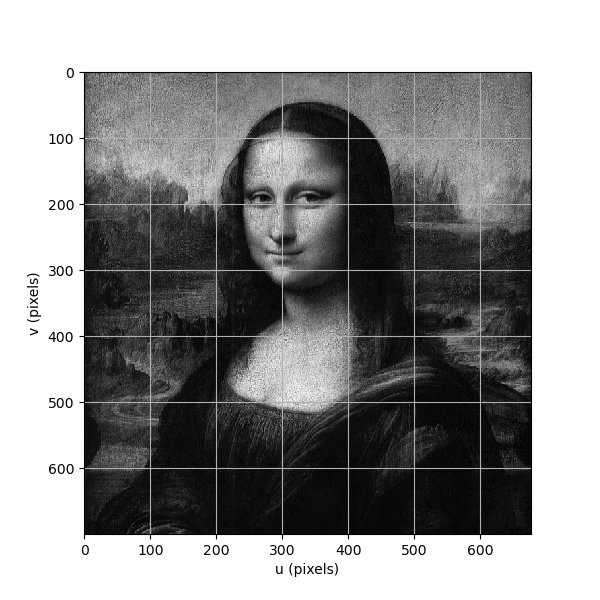

In [174]:
idisp(image)

**The notebook image view is interactive. If you drift your cursor over the image it displays, beneath, the pixel coordinate and the grey value of the pixel.**  

You can turn that feature off by clicking the blue button containin the "power switch" icon.

In [175]:
image[0,0]

53

Common indexing error:

In [176]:
image[700,0]

IndexError: index 700 is out of bounds for axis 0 with size 700

Now index is not out of bounds:

In [47]:
image[677,0]

15

<table>
  <tr>
    <td><div align="left"><font size="18">2. Basic Image Processing</font></div></td>
  </tr>
</table>

Let's increase the image **brightness**

<IPython.core.display.Javascript object>


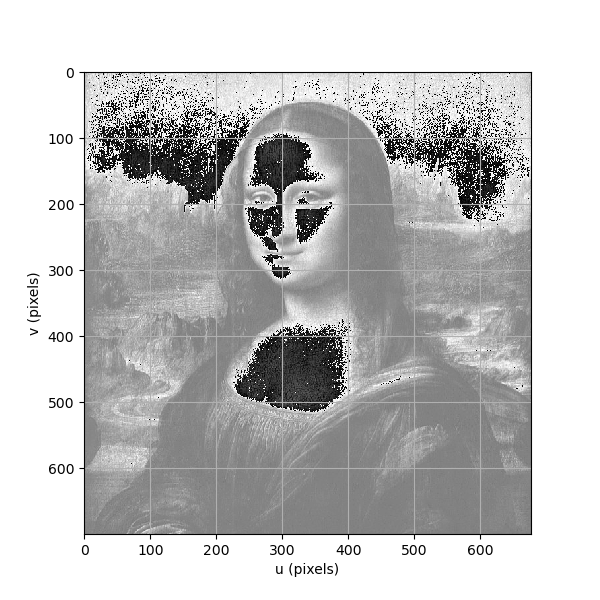

In [124]:
added = 120
image2 = image+added 
idisp(image2)

Problem: Mona Lisa not looking good:(

Reason: Some pixel values are overflowing!

Solution: cap pixel values to [0,255] interval

But to do this, we need to first cast the image to uint16 ([0, 65535]), then cast it back

In [127]:
image_16bit = np.array(image.astype(np.uint16))
image_16bit.dtype

dtype('uint16')

### Increasing brightness

<IPython.core.display.Javascript object>


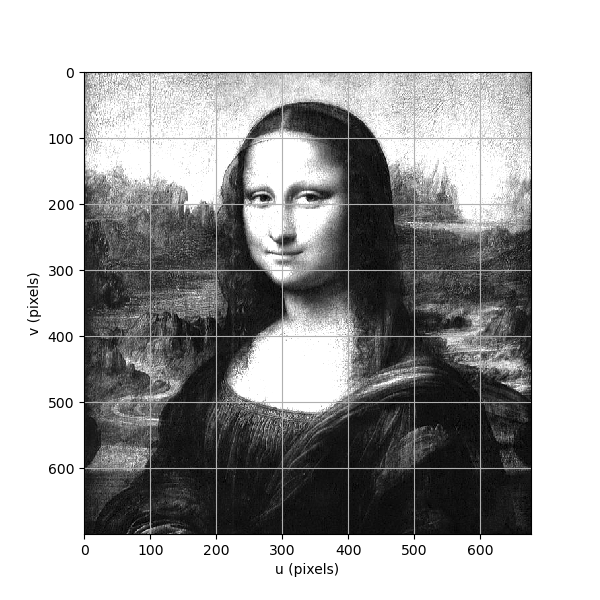

In [126]:
image2 = np.clip(image_16bit+added, 0, 255).astype(np.uint8)
idisp(image2)

### Changing contrast

<IPython.core.display.Javascript object>


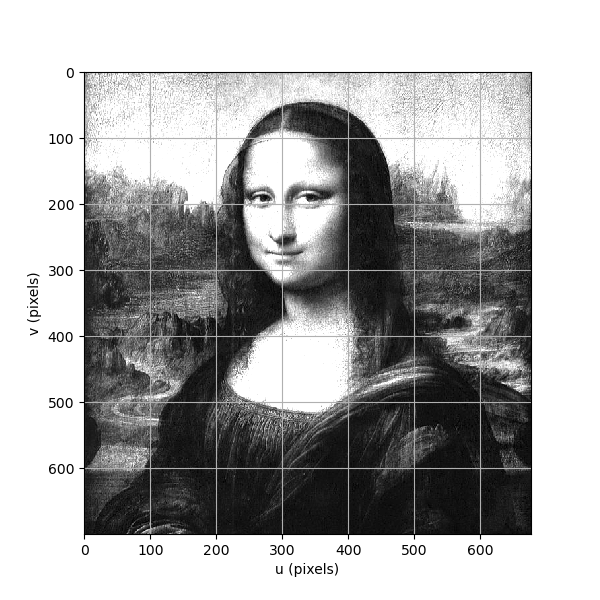

In [134]:
contrast_factor = 2
image2 = np.clip(image_16bit*contrast_factor, 0, 255).astype(np.uint8)
idisp(image2)

### Negative Image

<IPython.core.display.Javascript object>


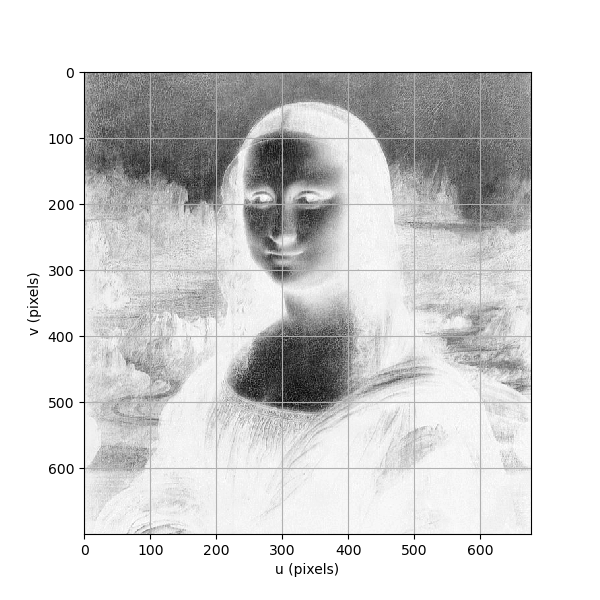

In [136]:
image2 = 255-image
idisp(image2)

### Thresholding

The resulting image only has 2 values:

false (black) if x<T

true (white) if x>=T

<IPython.core.display.Javascript object>


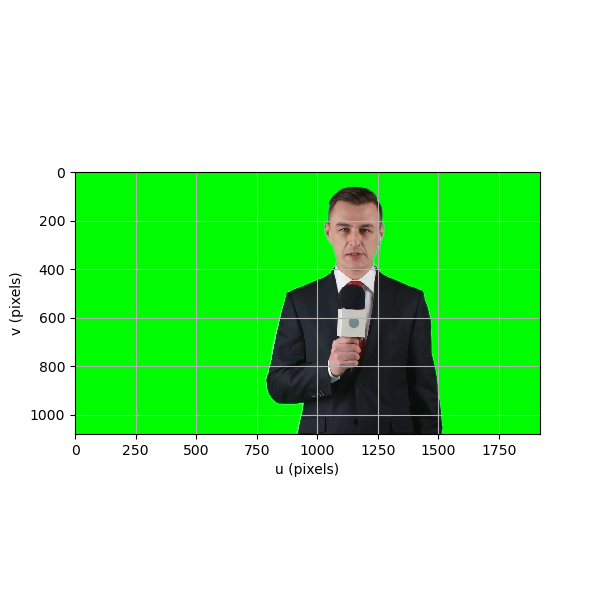

In [181]:
image3 = iread_color('green_screen.png')
idisp(image3)

<IPython.core.display.Javascript object>


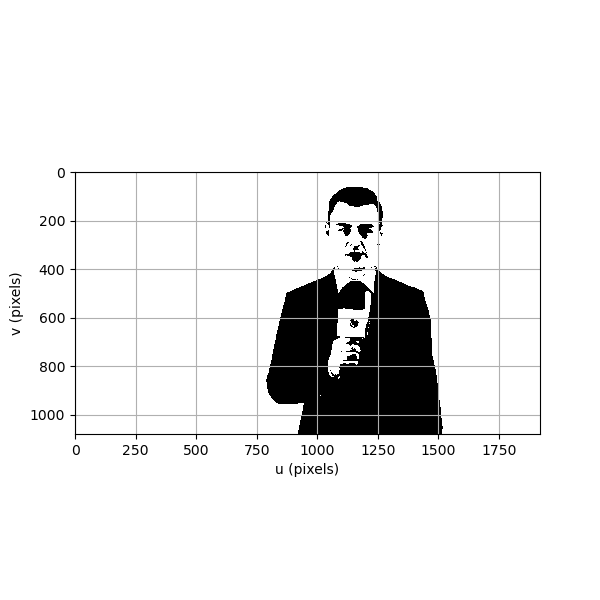

In [183]:
image3 = iread('green_screen.png')
threshold = 130
idisp(image3>threshold)

### Gaussian Blur

<IPython.core.display.Javascript object>


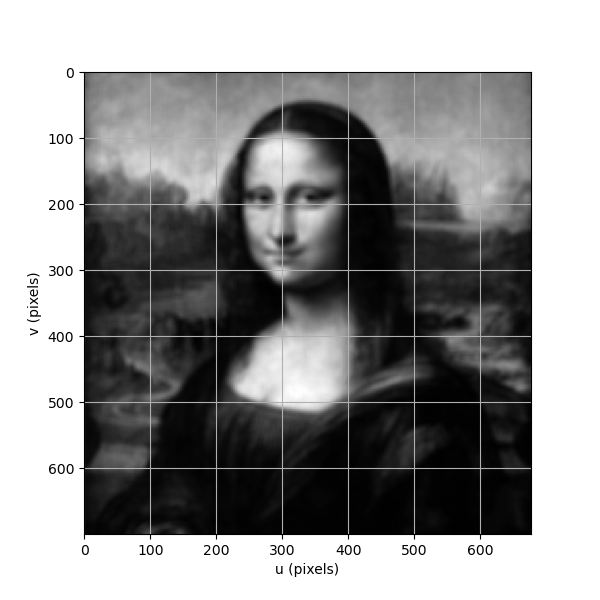

In [195]:
kernel_size = 11 # Window size must be odd!
sigmaX = 5
sigmaY = 5
blur = cv2.GaussianBlur(image,(kernel_size,kernel_size), sigmaX, sigmaY)
idisp(blur)

### Flux Question (1pt) 
What is the effect of increasing kernel size for Gaussian blur?

### Flux Question (1pt) 
Which one of the image operations we have seen is diadic?

<table>
  <tr>
    <td><div align="left"><font size="18">3. Feature Extraction</font></div></td>
  </tr>
</table>

## Corner Detection

<IPython.core.display.Javascript object>


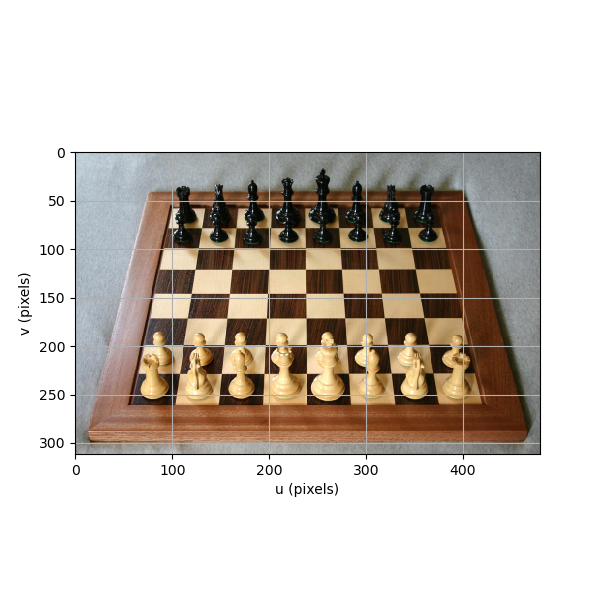

<IPython.core.display.Javascript object>


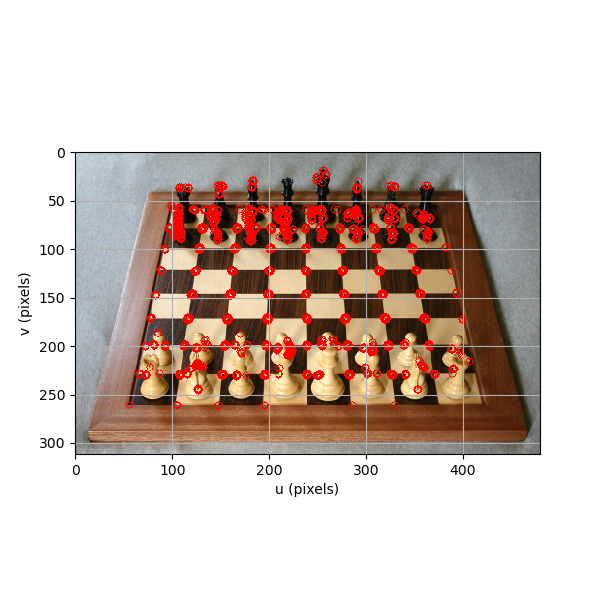

In [28]:
# input image
image_chessboard_color = iread_color('chessboard.jpg')
idisp(image_chessboard_color, interaction=False)

# Convert input img to 32bit, grayscale image
image_chessboard = iread('chessboard.jpg')
image_chessboard = np.float32(image_chessboard)

# Harris corner detector
out = cv2.cornerHarris(image_chessboard,2,3,0.04)

# Threshold for Harris corner detector
corner_threshold = 0.05

circle_radius = 4
circle_color = (255,0,0)
circle_thickness = 0

# Draw circles around the corners for better visibility 
for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        if out[i,j]>corner_threshold*out.max():
            cv2.circle(image_chessboard_color, (j,i), circle_radius, circle_color, circle_thickness)

            
#Display image
#plt.imshow(image_chessboard_color)
idisp(image_chessboard_color,interaction=False)

## Edge Detection and Line Detection



<IPython.core.display.Javascript object>


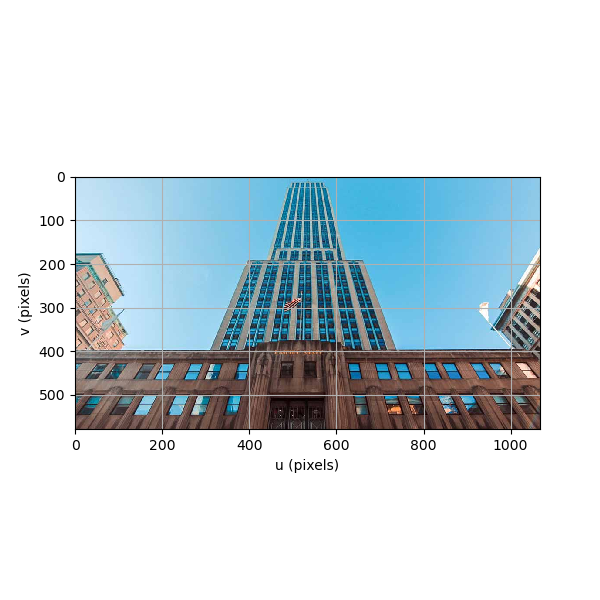

<IPython.core.display.Javascript object>


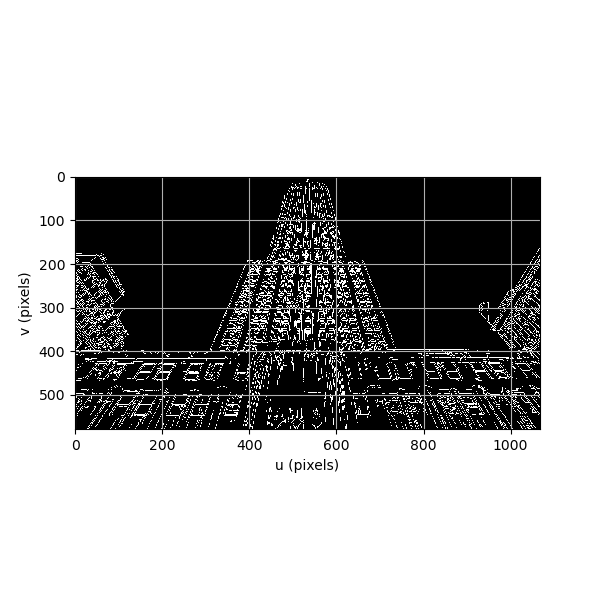

<IPython.core.display.Javascript object>


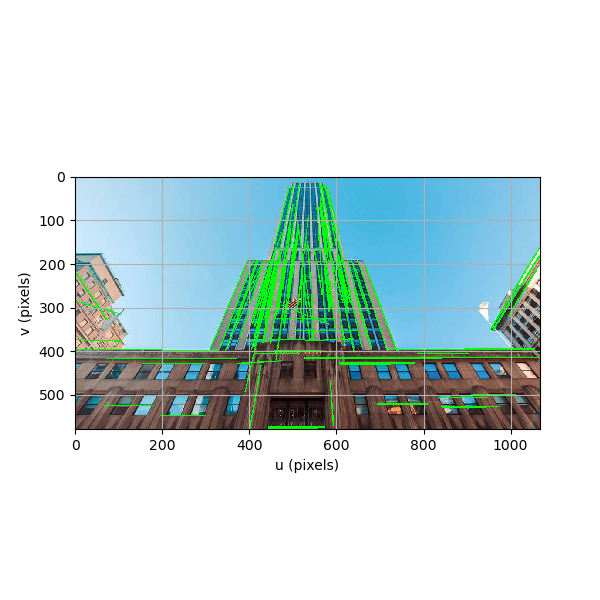

In [47]:
# Read input img
image_fed_sq_color = iread_color('empire_state.jpg')
idisp(image_fed_sq_color)

# Canny Edge Detection
#threshold1=first threshold for the hysteresis procedure.
#threshold2=second threshold for the hysteresis procedure.
edges = cv2.Canny(image=image_fed_sq_color, threshold1=100, threshold2=200)
idisp(edges)

# Hough Transform for Line Detection
#rho=Distance resolution of the accumulator in pixels.
#theta=Angle resolution of the accumulator in radians.
#hough_threshold = Accumulator threshold parameter. Only those lines are returned that get enough votes ( >threshold ).
#minLineLength=Minimum line length. Line segments shorter than that are rejected.
#maxLineGap=Maximum allowed gap between points on the same line to link them.
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=100, maxLineGap=10)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(image_fed_sq_color,(x1,y1),(x2,y2),(0,255,0),2)
idisp(image_fed_sq_color)


## Feature Descriptors 

<IPython.core.display.Javascript object>


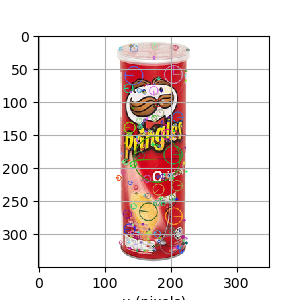

In [98]:
# Get input image
pringles_original_color = iread_color('pringles_can.png')
pringles_original_gray = iread('pringles_can.png')

# Create SIFT Descriptor
sift = cv2.SIFT_create()

# Detect SIFT Keypoints
kp = sift.detect(pringles_original_gray,None)

pringles_original_color=cv2.drawKeypoints(pringles_original_color, kp, pringles_original_color, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
idisp(pringles_original_color, small=True)

## Feature Matching

<IPython.core.display.Javascript object>


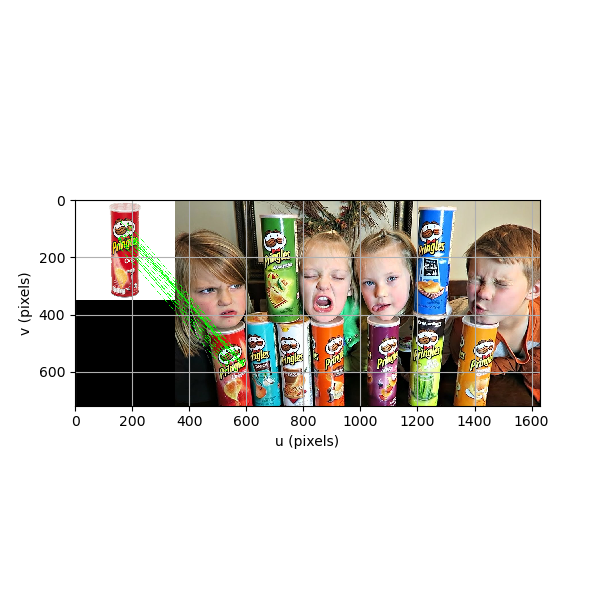

In [108]:
# Get input image
input_img_str = 'pringles_can.png'
pringles_color = iread_color(input_img_str)
pringles_gray = iread(input_img_str)

# Get Test Image
test_img_str = 'pringles_test3.jpg'
pringles_test_color = iread_color(test_img_str)
pringles_test_gray = iread(test_img_str)

# Create SIFT Descriptor
sift = cv2.SIFT_create()

# Detect SIFT Keypoints
kp1, des1 = sift.detectAndCompute(pringles_gray,None)
kp2, des2 = sift.detectAndCompute(pringles_test_gray,None)

# FLANN stands for Fast Library for Approximate Nearest Neighbors
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
ratio_test_threshold = 0.9
good = []
for m,n in matches:
    if m.distance < ratio_test_threshold*n.distance:
        good.append(m)

#Now we set a condition that atleast 10 matches (defined by MIN_MATCH_COUNT) are to be there to find the object. Otherwise simply show a message saying not enough matches are present.
MIN_MATCH_COUNT = 5

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = pringles_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    pringles_test_gray = cv2.polylines(pringles_test_gray,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(pringles_color,kp1,pringles_test_color,kp2,good,None,**draw_params)
idisp(img3)

### Flux Question (1pt) 
Test the system with test images pringles_test1.jpg to pringles_test4.jpg. What is one of the biggest problems with keypoint matching based object detection?